In [1]:
""" Add images into a pandas Dataframe
"""
from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets.vision import VisionDataset
import collections
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.patches as patches
from torch.autograd import Variable


In [2]:
# READING FILE FROM THE FOLDER STORINNG THE PATH AND LABEL OF EACH IMAGE IN PANDA DATAFRAME
# with Mask has Label 1 
# without Mask has label 0

datasetPath = Path('dataset')
maskPath = datasetPath/'with mask'
nonMaskPath = datasetPath/'without mask'
maskDF = pd.DataFrame()

for subject in tqdm(list(maskPath.iterdir()), desc='mask photos'):
    maskDF = maskDF.append({
            'image': str(subject),
            'mask': 1
        }, ignore_index=True)
    

for subject in tqdm(list(nonMaskPath.iterdir()), desc='non mask photos'):
        maskDF = maskDF.append({
            'image': str(subject),
            'mask': 0
        }, ignore_index=True)

non mask photos: 100%|██████████████████████████████████████████████████████████████| 686/686 [00:02<00:00, 288.75it/s]


In [3]:
# SPLITTING THE DATA IN TO TRAIN AND VALIDATION WITH 80% TRAIN DATA and 20 % TEST DATA

train_df, validate_df = train_test_split(maskDF, test_size=0.20, random_state=0,
                                           stratify=maskDF['mask'])
print(train_df.shape)
print(validate_df.shape)

(1100, 2)
(276, 2)


In [4]:
# CREATING CLASS TO CREATE DATASETS IN CORRECT FORMAT FOR DATA LOADER 
class CustomDataset(VisionDataset):
    def __init__(
            self,
            dataFrame,
            transform = None,
            target_transform = None,
    ) -> None:

        super(CustomDataset, self).__init__(dataFrame, transform=transform,
                                      target_transform=target_transform)
        self.data: Any = []
        self.targets = []
        for index, row in dataFrame.iterrows(): 
                img=cv2.imread(row['image'])
                img=cv2.resize(img,(100,100))
                
                self.data.append(img)
                self.targets.extend([int(row['mask'])])
                
        self.data = np.reshape(self.data,(len(self.data),100,100,3))
    
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    def __len__(self) -> int:
        return len(self.data)

In [7]:
# Hyperparameters
num_epoch = 5
batch_size = 10
learning_rate = 0.001


# CONVERTING THE DATASET INTO TRAIN AND TEST LOADER
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train = CustomDataset(train_df,transform = transform)
validate = CustomDataset(validate_df,transform = transform)

train_loader = torch.utils.data.DataLoader(train,batch_size = batch_size,shuffle= True)
test_loader = torch.utils.data.DataLoader(validate,batch_size = batch_size,shuffle=False)


In [4]:
## CREATING CNN FOR MASK DETECTION
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,200,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(200,100,3)
        
        self.fc1 = nn.Linear(100*23*23, 50)
        
        self.fc2 = nn.Linear(50,2)
        self.dropout = nn.Dropout(0.5)
        
    
    def forward(self,x):
            x = self.pool( F.relu(  self.conv1(x)  ) )
            x = self.pool( F.relu(  self.conv2(x)  ) )
            
            x = x.view (-1,100*23*23)
            x = self.dropout(x)
            x = F.relu(  self.fc1(x)  )
            x = self.fc2(x)
        
            return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epoch):
    for i ,(images,labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        #backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print("Finished Training")

Epoch [1/5], Step [50/110], Loss: 0.4068
Epoch [1/5], Step [100/110], Loss: 0.3358
Epoch [2/5], Step [50/110], Loss: 0.2053
Epoch [2/5], Step [100/110], Loss: 0.2528
Epoch [3/5], Step [50/110], Loss: 0.0010
Epoch [3/5], Step [100/110], Loss: 0.1127
Epoch [4/5], Step [50/110], Loss: 0.0071
Epoch [4/5], Step [100/110], Loss: 0.0033
Epoch [5/5], Step [50/110], Loss: 0.0005
Epoch [5/5], Step [100/110], Loss: 0.0026
Finished Training


In [9]:
## Calculating Accuracy score on Train and Test data
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value,index)
        _,predicted = torch.max(outputs,1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    print(f'Accuracy of the network Train data: {acc} %')
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value,index)
        _,predicted = torch.max(outputs,1)
        
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    
    print(f'Accuracy of the network test data: {acc} %')        


Accuracy of the network Train data: 99.36363636363636 %
Accuracy of the network test data: 97.46376811594203 %


In [24]:
conv1 = nn.Conv2d(3,200,3)
pool  = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(200,100,3)

print(images.shape)
x = conv1(images)
print(x.shape)

x=pool(x)
print(x.shape)

x = conv2(x)
print(x.shape)

x = pool(x)
print(x.shape)

print(100*23*23)

torch.Size([8, 3, 100, 100])
torch.Size([8, 200, 98, 98])
torch.Size([8, 200, 49, 49])
torch.Size([8, 100, 47, 47])
torch.Size([8, 100, 23, 23])
52900


In [16]:
def faceMaskDetection(imagePath):
    faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    source=cv2.VideoCapture(0)

    labels_dict={0:'NO MASK',1:'MASK'}
    color_dict={0:'red',1:'green'}

    # img = np.array(img)
    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.3, 5)

    face_image=[]
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,4))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    for (x,y,w,h) in faces:

        face_img=img[y:y+w,x:x+w]
        res_face_img = cv2.resize(face_img,(100,100))
        
        image_tensor = transform(res_face_img)
       
        image_tensor_final = image_tensor.unsqueeze_(0)
        
        input = Variable(image_tensor_final)
        input = input.to(device)
        output = model(input)
        _,predicted = torch.max(output,1)
        label = predicted.item()
    #     cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    #     cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    #     cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

        bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_dict[label], facecolor='none')
        ax.add_patch(bbox)
        plt.text(x, y-12, s=labels_dict[label], color='white', verticalalignment='top',
                    bbox={'color': color_dict[label], 'pad': 0})


    plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

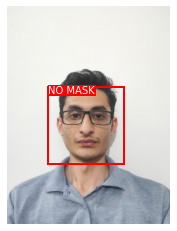

<Figure size 432x288 with 0 Axes>

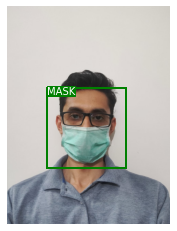

In [19]:
faceMaskDetection("images/r2.jpeg")
faceMaskDetection("images/r1.jpeg")

<Figure size 432x288 with 0 Axes>

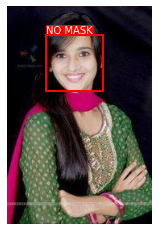

<Figure size 432x288 with 0 Axes>

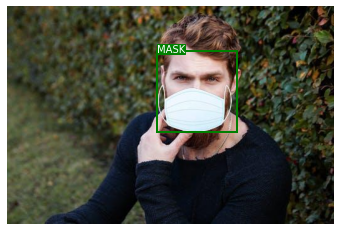

<Figure size 432x288 with 0 Axes>

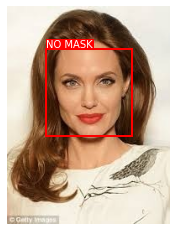

In [21]:
faceMaskDetection("images/0.jpg")
faceMaskDetection("images/1.jpg")
faceMaskDetection("images/23.jpg")

In [10]:
## DETECTING FACE MASK ON LIVE WEBCAM FEED
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
labels_dict={0:'NO MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}
source=cv2.VideoCapture(0)
while(True):
    ret,img=source.read()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    for (x,y,w,h) in faces:
        face_img=img[y:y+w,x:x+w]
        res_face_img = cv2.resize(face_img,(100,100))

        image_tensor = transform(res_face_img)

        image_tensor_final = image_tensor.unsqueeze_(0)

        input = Variable(image_tensor_final)
        input = input.to(device)
        output = model(input)
        _,predicted = torch.max(output,1)
        label = predicted.item()

#         cv2.rectangle(img,(x,y),(x+w,y+h), (0, 0, 0),3)
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

In [2]:
PATH = "face_model_final.pt"

# Save
# torch.save(model, PATH)


In [5]:
# Load
model = torch.load(PATH)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 200, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=52900, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)